Load Meta-data file and one `.mat` file representing a whole session. Usint metadata and data from session file an experiment (`emgframework.model.model.Experiment`) is created.

`emgframework` is something Patrick is developing in the scope of his IDP. It represents an experiment involving EMG/EEG data and offers some functionality to work with this data.

In [7]:
# These packages enable reloading a module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
print os.getcwd()

/home/patrick/GitHub/interdisciplinary_project


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import emg.data as data
import model.model as model
import emg.display as display
import model.knowledgeBase as kb
from sklearn.linear_model import LinearRegression

In [10]:
metadata = data.read_meta_file('data/P1/P1_AllLifts.mat')

In [11]:
session_data = data.read_session('data/P1/HS_P1_S1.mat')

Creating a Knowledge Base
===

The model is created remotely like you would create a KB in Prolog:
```
experiment = model.Experiment()
subject = model.Subject('subject1')
setup = model.Setup(experiment)

modality = model.Modality(setup, ,'sample rate', 'modality name')
sample = model.Sample(modality, 'sample 1')
...
sample = model.Sample(modality, 'sample n')

session = model.Session(experiment, setup, subject, 'session name')
# Passing on the identifier of the modality is necessary to support multiple recordings from different technologies 
# (EMG, EEG) in one session
# Data can either be a pandas.core.DataFrame, numpy.ndarray or a path to a pickled file containing one of those.
# Additional backends for other file types can be easily added
recording = model.Recording(session, data, identifier, modality.Identifier)
trial = model.Trial(recording, starttime, duration, identfier, label)
tiral.add_marker((time, 'some event'))
...
trial = model.Trial(recording, starttime, duration, identfier, label)
tiral.add_marker((time, 'some event'))
```
In this way the experiment can be modeled. Checkout ``emg/data.py`` for a complex example or ``model.knowledgebase.py`` for some simple ones

In [12]:
markers = ['tHandStart', 'tLiftOff', 'tReplace']
experiment = kb.create_emg_eeg_kb(meta=metadata, sessions=[session_data], markers=markers)

model/knowledgeBase.py:560: UserWarning: WARNING - EEG data does not contain enough data points. Has 119496 data points but 119496 are required. Skipped Lift 33
  warnings.warn(warning)


In [13]:
print experiment.recursive_to_string()

Experiment: 1 Setups, 1 Sessions, 0 Subjects
Subjects:
Setups:
	Setup setup0: 3 Modalities
		Modality emg: 5 Samples, 4000 Hz
			Sample: First Dorsal Interosseus
			Sample: Brachoradial
			Sample: Anterior Deltoid
			Sample: Flexor Digitorum
			Sample: Common Extensor Digitorum
		
		Modality eeg: 32 Samples, 500 Hz
			Sample: P3
			Sample: Pz
			Sample: O2
			Sample: O1
			Sample: P7
			Sample: P4
			Sample: T8
			Sample: Fz
			Sample: C3
			Sample: TP9
			Sample: C4
			Sample: FC1
			Sample: FC2
			Sample: FC5
			Sample: FC6
			Sample: PO9
			Sample: T7
			Sample: P8
			Sample: PO10
			Sample: Fp1
			Sample: Oz
			Sample: Fp2
			Sample: F3
			Sample: F4
			Sample: F7
			Sample: F8
			Sample: TP10
			Sample: Cz
			Sample: CP1
			Sample: CP2
			Sample: CP5
			Sample: CP6
		
		Modality kin: 12 Samples, 500 Hz
			Sample: Px4 - position x sensor 4
			Sample: Py3 - position y sensor 3
			Sample: Py1 - position y sensor 1
			Sample: Pz4 - position z sensor 4
			Sample: Px2 - position x senso

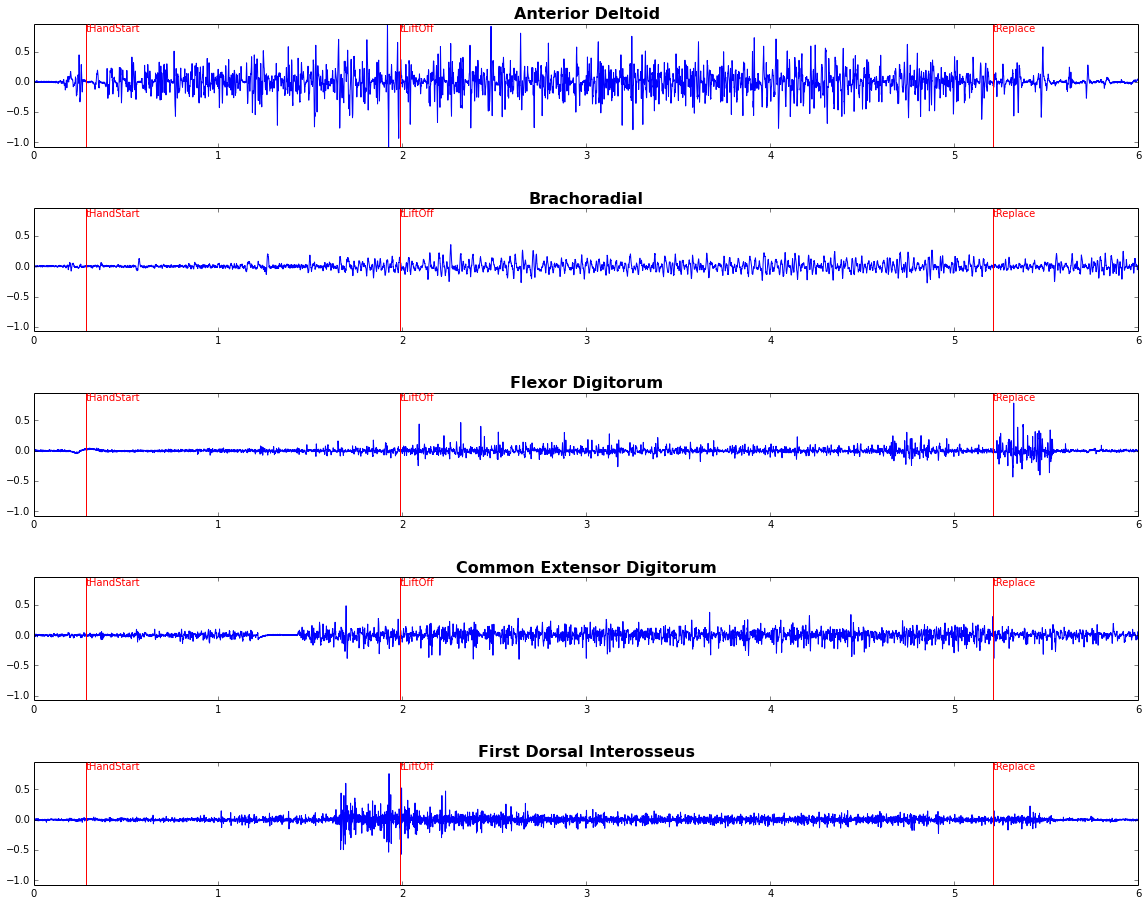

In [14]:
start = 0
stop = 6
display.visualize_modality(model=experiment, start=0, stop=stop, modality='emg')

In [ ]:
plt.plot

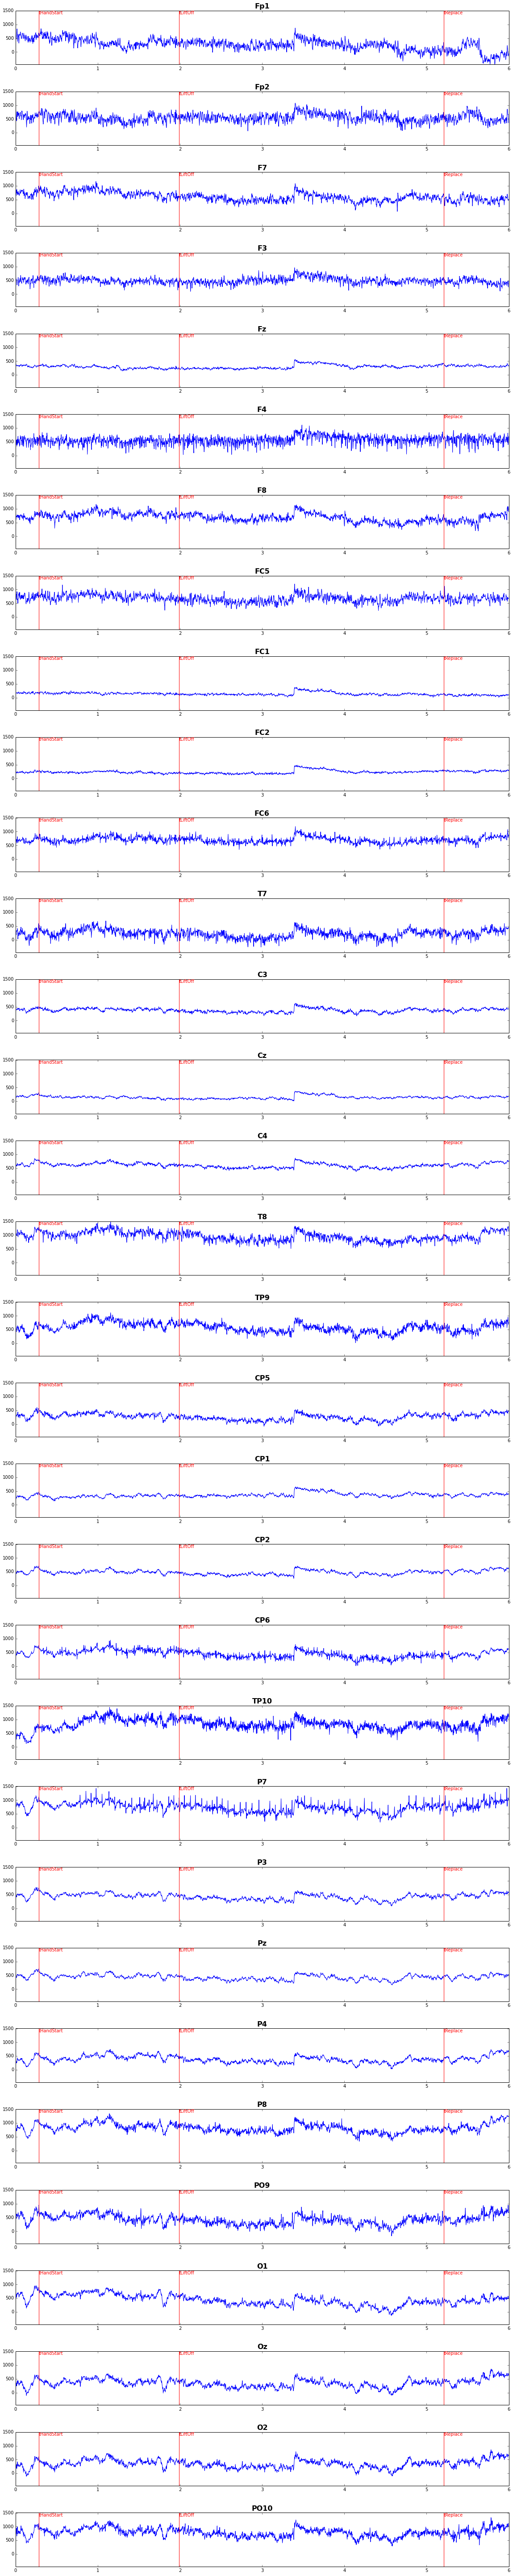

In [18]:
start = 0
stop = 6
display.visualize_modality(model=experiment, start=0, stop=stop, modality='eeg')

## Training a linear model to predict kartesian coordinates - For each time step
The following cells show how to prepare data and train a linear model to predict to position of the arm given the
EMG signal.
The prediction is done for every time step, though.

First rectification of the signal is performed

In [15]:
rec_data = abs(experiment.Sessions['session_1'].Recordings['emg_data'].get_data(pandas=False))
experiment.Sessions['session_1'].Recordings['emg_data'].set_data(rec_data)

Next the positional data and emg data are aligned, that is EMG has a higher sampling rate than kinematic data so a proportial amount of samples of the EMG data are collapsed. EMG and KIN data now have the same length

In [16]:
kinr = experiment.Sessions['session_1'].Recordings['kin_data']
aligned_emg = data.align_by_median(experiment.Sessions['session_1'].Recordings['emg_data'],
                             experiment.Sessions['session_1'].Recordings['kin_data'])

Define Samples which should be used as targets. Create training, validation and test sets

In [17]:
cols = ['Px1 - position x sensor 1',
        'Py1 - position y sensor 1',
        'Pz1 - position z sensor 1'
       ]

In [18]:
X, Z, VX, VZ, TX, TZ = data.train_valid_test_from_lists(
    [aligned_emg],
    kinr.get_trials_as_list(samples=cols, pandas=False)
    )

Create and train a linear model. Then make prediction and visualize them

In [19]:
m = LinearRegression()
m.fit(X, Z)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
Y = m.predict(X)
VY = m.predict(VX)
TY = m.predict(TX)

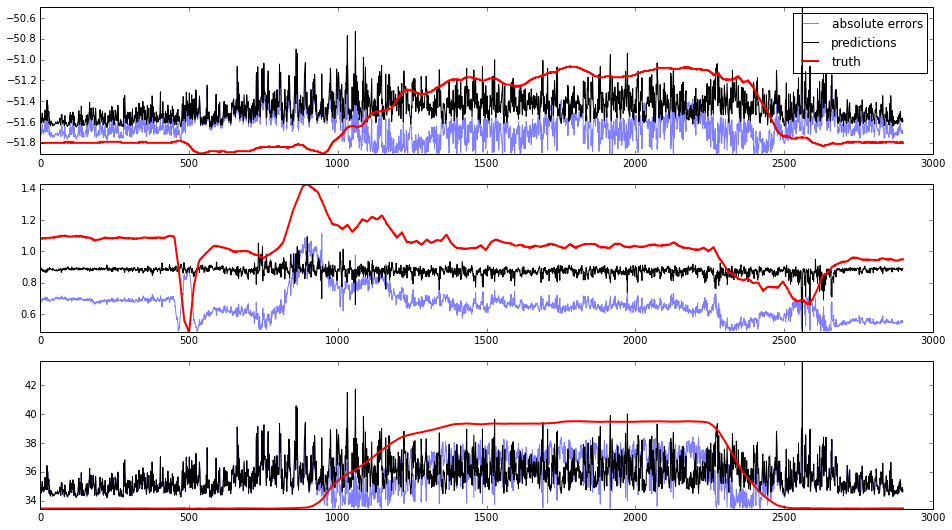

In [21]:
start, stop = 100, 3000
display.predict_report(X[start:stop], Y[start:stop], Z[start:stop])

## Training Linear Model to predict Cartesian Coordinates - Sequence Wise
In contrast to earlier, in this section the model becomes a whole sequence of times steps. The target is the last cartesian coordinate of the sequence.

Exemplary, we have a sequence (time window) of ten samples, **_X_** = *{* **_x1_**, **_x2_**, ..., **_x10_** *}*, where each sample is a vector of length 5 and the corresponding targets **_Z_** = *{* **_z1_**, ...,**_z10_** *}* where each target is a vector of length three. So **_X_** is *10x5* and **_Z_** is *10x3*.

For sequence prediction we flatten out **_X_** to a vector **_v_** of length 50 and use the last target in **_Z_** as target for **_v_**.
The resulting training sample looks then like this:

**_v_** = *(x1,1; x1,2; ...; x1,5; x2,1; ...;x2,5; x3,1; ...; x10, 5)* --> *(z10,1; z10,2; z10, 3)*

First we windowify the data:

In [22]:
wdata, wtargets = data.windowify_labeled_data_set(
    aligned_emg,
    kinr.get_trials_as_list(samples=cols, pandas=False),
    length=2000, 
    offset=100
    )

Create training, validation and test set:

In [23]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = data.sets_for_sequence_learning(wdata, wtargets)

Train a linear model, predict errors and visualize the (in this case) error on the *test set*:

In [24]:
m_seq = LinearRegression()
m_seq.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
Y = m_seq.predict(train_X)
VY = m_seq.predict(val_X)
TY = m_seq.predict(test_X)

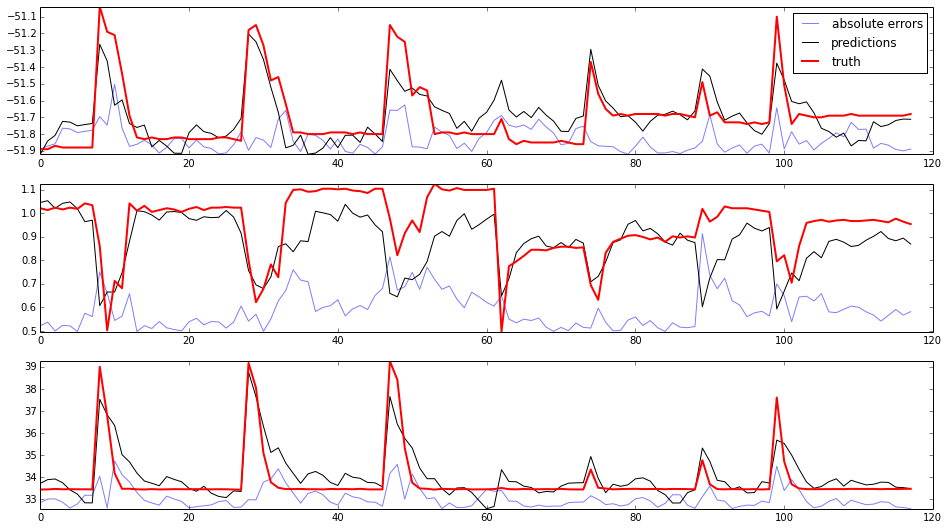

In [26]:
start, stop = 10, 2000
display.predict_report(test_X[start:stop], TY[start:stop], test_Y[start:stop])